Halfway There adoption analysis

Created by : Luis E. Ariza

02/06/2020

Welcome to this document explaining the steps in analysis and modeling for the adoption of Halfway There

This analysis was guided by two main questions:

1. What kind of customers are signing up for Halfway There?

2. What can we do to improve the promotion of Halfway There?

Each cell in this document is preceded by a markdown cell summarizing the steps followed for the analysis and highlighting the main findings. Each cell presents the code and output for each analysis and modeling step.

The procedure was as follows:

1. Libraries and data loading, creation of flags for outliers and missing values. Creation of email related variables

2. Creation of new features based on engagement metrics

3. Exploratory analysis: all variables vs response variable

4. Closer look on FOLLOWED_RECOMMENDATIONS_PCT

5. Closer look on EMAIL

6. Model evaluation

7. Training of final model


1. Libraries and data loading, creation of flags and email related variables

The distribution of all variables was checked beforehand, outlier thresholds were chosen and flags created. Using the information provided by Marketing, emails were classified as either "professional", "personal", or "junk". Dummy variables were created according to this categorization. Name related variables were dropped as names were all fictional.

In [2]:
# Libraries are imported 

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import display

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score 

from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

# Display settings are changed to make it easier to look at .describe() results

pd.set_option('display.max_columns', 500)

pd.set_option('display.max_rows', 500)

# Dataset is loaded

file = "Apprentice_Chef_Dataset.xlsx"

df = pd.read_excel(file)

# Outlier flags, threshold definition

total_meals_out = 300

unique_meals_out = 10

customer_care_out = 12

avg_time_out = 250

cancel_pre_noon_out = 7

late_deliv_out = 10

prep_time_out = 300

avg_clicks_out = 7 #Outliers on the left side

photos_clicked_out = 500

weekly_out = 30

early_out = 7


# Outlier flags, feature creation

df.loc[:,"out_total_meals"] = 0

condition = df.loc[:,"out_total_meals"][df.loc[:, "TOTAL_MEALS_ORDERED"] > total_meals_out]

df.loc[:,"out_total_meals"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_unique_meals"] = 0

condition = df.loc[:,"out_unique_meals"][df.loc[:, "UNIQUE_MEALS_PURCH"] > unique_meals_out]

df.loc[:,"out_unique_meals"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_customer_care"] = 0

condition = df.loc[:,"out_customer_care"][df.loc[:, "CONTACTS_W_CUSTOMER_SERVICE"] > customer_care_out]

df.loc[:,"out_customer_care"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_avg_time"] = 0

condition = df.loc[:,"out_avg_time"][df.loc[:, "AVG_TIME_PER_SITE_VISIT"] > avg_time_out]

df.loc[:,"out_avg_time"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_cancel_noon"] = 0

condition = df.loc[:,"out_cancel_noon"][df.loc[:, "CANCELLATIONS_BEFORE_NOON"] > cancel_pre_noon_out]

df.loc[:,"out_cancel_noon"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_late_deliv"] = 0

condition = df.loc[:,"out_late_deliv"][df.loc[:, "LATE_DELIVERIES"] > late_deliv_out]

df.loc[:,"out_late_deliv"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_prep_time"] = 0

condition = df.loc[:,"out_prep_time"][df.loc[:, "AVG_PREP_VID_TIME"] > prep_time_out]

df.loc[:,"out_prep_time"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_avg_clicks"] = 0

condition = df.loc[:,"out_avg_clicks"][df.loc[:, "AVG_CLICKS_PER_VISIT"] < avg_clicks_out]

df.loc[:,"out_avg_clicks"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_photos_clicked"] = 0

condition = df.loc[:,"out_photos_clicked"][df.loc[:, "TOTAL_PHOTOS_VIEWED"] > photos_clicked_out]

df.loc[:,"out_photos_clicked"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_weekly"] = 0

condition = df.loc[:,"out_weekly"][df.loc[:, "WEEKLY_PLAN"] > weekly_out]

df.loc[:,"out_weekly"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

df.loc[:,"out_early"] = 0

condition = df.loc[:,"out_early"][df.loc[:, "EARLY_DELIVERIES"] > early_out]

df.loc[:,"out_early"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

# Missing value flags

df.loc[:,"miss_family_name"] = 0

condition = df.loc[:, "miss_family_name"][df.loc[:, "FAMILY_NAME"].isnull()]

df.loc[:,"miss_family_name"].replace(to_replace = condition,
                                   value = 1,
                                   inplace = True)

# A variable is created categorizing customer's emails as professional, personal or junk

# A new column is created with email domains

domain_vector = []

for email in df.loc[:, "EMAIL"]:
    
    domain_vector.append(email.split(sep = "@")[1])
    
df.loc[:, "email_domain"] = domain_vector

# Emails are classified according to the information provided by Marketing

professional = ["mmm.com", "amex.com", "apple.com", "boeing.com",
               "caterpillar.com", "chevron.com", "cisco.com",
               "cocacola.com", "disney.com", "dupont.com", "exxon.com",
               "ge.org", "goldmansacs.com", "homedepot.com", "ibm.com",
               "intel.com", "jnj.com", "jpmorgan.com", "mcdonalds.com",
               "merck.com", "microsoft.com", "nike.com", "pfizer.com",
               "pg.com", "travelers.com", "unitedtech.com", "unitedhealth.com",
               "verizon.com", "visa.com", "walmart.com"]

personal = ["gmail.com", "yahoo.com", "protonmail.com"]

junk = ["me.com", "aol.com", "hotmail.com", "live.com", "msn.com", "passport.com"]

email_type_vector = []

for email in df.loc[:, "email_domain"]:
    
    if email in professional:
        
        email_type_vector.append("professional")
        
    elif email in personal:
        
        email_type_vector.append("personal")
        
    elif email in junk:
        
        email_type_vector.append("junk")
        
    else:
        
        email_type_vector.append("other")
    
df.loc[:, "email_type"] = email_type_vector

# Creating dummy variables based on email type

email_dummies = pd.get_dummies(df.loc[:, "email_type"])

df = df.join(email_dummies)

# Dropping email related variables after encoding. 

# EMAIL will be kept for a further step

df = df.drop("email_domain", axis = 1)

df = df.drop("email_type", axis = 1)

# Dropping one of the dummy variables created to avoid colinearity

df = df.drop("personal", axis = 1)


# A new feature is created with the total meals purchased to weekly plans ratio

ratio_vector = []

for i in df.loc[:, "WEEKLY_PLAN"]:
    
    ratio_vector.append(df.loc[i, "WEEKLY_PLAN"] / df.loc[i, "TOTAL_MEALS_ORDERED"])
    
df.loc[:, "weekly_to_total_ratio"] = ratio_vector

# Name variables are dropped

df = df.drop("NAME", axis = 1)

df = df.drop("FIRST_NAME", axis = 1)

df = df.drop("FAMILY_NAME", axis = 1)

2. Creation of new features based on engagement metrics

It was hypothesized that customers would have different online behaviors according to their level of engagement with the service. With that in mind, new variables were created comparing mobile versus PC use, total logins, estimated total amount of clicks during the period observed, and how many product categories were seen according to both time spent and clicks per visit

In [3]:
# New variables 

df.loc[:, "total_logins"] = df.loc[:, "MOBILE_LOGINS"] + df.loc[:, "PC_LOGINS"]

df.loc[:, "mobile_to_pc_ratio"] = df.loc[:, "MOBILE_LOGINS"] / df.loc[:, "total_logins"]

df.loc[:, "estimated_total_clicks"] = df.loc[:, "total_logins"] * df.loc[:, "AVG_CLICKS_PER_VISIT"]

df.loc[:, "categories_to_clicks_ratio"] = df.loc[:, "PRODUCT_CATEGORIES_VIEWED"] / df.loc[:, "AVG_CLICKS_PER_VISIT"]

df.loc[:, "categories_to_time_ratio"] = df.loc[:, "PRODUCT_CATEGORIES_VIEWED"] / df.loc[:, "AVG_TIME_PER_SITE_VISIT"]

3. Exploratory analysis: All variables vs response variable

The distribution of the response variable was checked. The majority of customers in the dataset are Halfway There adopters, but yet the variable does not suffer from class imbalance. Correlations were calculated against the response variable. Two variables "FOLLOWED_RECOMMENDATIONS_PCT" and "junk" were found to have medium to weak correlation scores. Also "professional" and "CANCELLATIONS_BEFORE_NOON" were found to have weak correlations. All other variables had even lower scores and were given a lower priority.

In [4]:
display(df.loc[:, "CROSS_SELL_SUCCESS"].value_counts())

corr_scores = df.corr()

corr_scores.loc[:, "CROSS_SELL_SUCCESS"].sort_values(ascending = False)

1    1321
0     625
Name: CROSS_SELL_SUCCESS, dtype: int64

CROSS_SELL_SUCCESS              1.000000
FOLLOWED_RECOMMENDATIONS_PCT    0.464387
professional                    0.194102
CANCELLATIONS_BEFORE_NOON       0.163442
MOBILE_NUMBER                   0.102657
TASTES_AND_PREFERENCES          0.081438
REFRIGERATED_LOCKER             0.068321
mobile_to_pc_ratio              0.060210
MOBILE_LOGINS                   0.044462
PACKAGE_LOCKER                  0.043534
MASTER_CLASSES_ATTENDED         0.037213
CONTACTS_W_CUSTOMER_SERVICE     0.036541
out_cancel_noon                 0.034043
AVG_PREP_VID_TIME               0.032115
MEDIAN_MEAL_RATING              0.031798
out_early                       0.024384
weekly_to_total_ratio           0.023851
out_prep_time                   0.022872
LARGEST_ORDER_SIZE              0.022000
categories_to_clicks_ratio      0.019348
out_late_deliv                  0.018558
EARLY_DELIVERIES                0.015112
miss_family_name                0.015019
AVG_TIME_PER_SITE_VISIT         0.011117
TOTAL_PHOTOS_VIE

Boxplots and bar graphs were plotted to look at the way Halfway There adopters fall within "FOLLOWED_RECOMMENDATIONS_PCT", "CANCELLATIONS_BEFORE_NOON" and the email related variables. 

--------------------------------------------------------------------------------
All customers above 30% in followed recommendations are adopters
--------------------------------------------------------------------------------


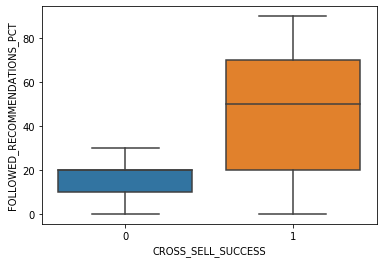

--------------------------------------------------------------------------------
Only 12% of adopters registered a junk email
--------------------------------------------------------------------------------


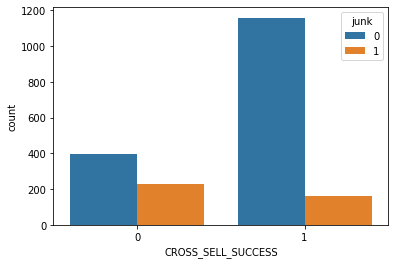

--------------------------------------------------------------------------------
80% of customers with a professional email are adopters
--------------------------------------------------------------------------------


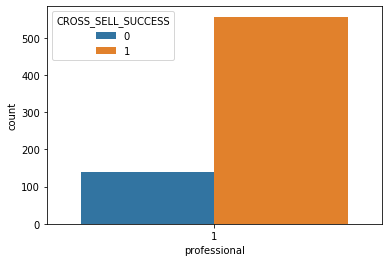

--------------------------------------------------------------------------------
Differences are not great in terms of cancellations before noon
--------------------------------------------------------------------------------


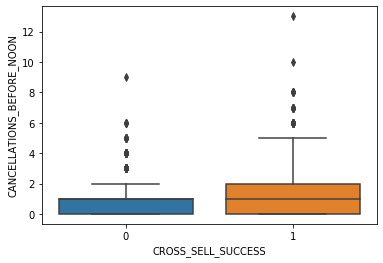

In [5]:
print("-" * 80, "\nAll customers above 30% in followed recommendations are adopters\n", "-" * 80, sep = "")

sns.boxplot(y = df.loc[:, "FOLLOWED_RECOMMENDATIONS_PCT"],
               x = df.loc[:, "CROSS_SELL_SUCCESS"])
plt.show()

print("-" * 80, "\nOnly 12% of adopters registered a junk email\n", "-" * 80, sep = "")

sns.countplot(df.loc[:, "CROSS_SELL_SUCCESS"], hue = df.loc[:, "junk"])

plt.show()

print("-" * 80, "\n80% of customers with a professional email are adopters\n", "-" * 80, sep = "")

sns.countplot(df.loc[df.professional == 1, "professional"], hue = df.loc[:, "CROSS_SELL_SUCCESS"])

plt.show()

print("-" * 80, "\nDifferences are not great in terms of cancellations before noon\n", "-" * 80, sep = "")

sns.boxplot(y = df.loc[:, "CANCELLATIONS_BEFORE_NOON"],
               x = df.loc[:, "CROSS_SELL_SUCCESS"])
plt.show()

4. Closer look on FOLLOWED_RECOMMENDATIONS_PCT

Since "FOLLOWED_RECOMMENDATIONS_PCT" is the variable with the highest correlation, and all customers above 30% were found to be adopters, it was hypothesized that adopters make most of their purchases because of consumer inertia, see a definition in Dubé et.al (2010). If that was the case, differences could be expected in browsing behavior between adopters and rejecters, that is, customers buying due to inertia would have shorter browsing times and a lesser amount of clicks. 

A new variable was created dividing the dataset between those who followed recommendations above and below 30%. Distributions were plotted and reviewed for all variables, the next cell shows the frame work used. To keep this document light, the cell will only output plots and comparisons for one variable.

No important differences were found for any of the browsing related variables in the dataset. While this finding does not completely eliminate the possibility of consumer inertia, it shows that the tendency to follow recommendations is not explained by browsing habits. This could imply that our platform is not creating differentiation for those customers with a high propensity to sign up to Halfway There.

--------------------------------------------------------------------------------
Followed recommendations over 30% of the times
--------------------------------------------------------------------------------


count    784.000000
mean       2.788265
std        0.752053
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: MEDIAN_MEAL_RATING, dtype: float64

--------------------------------------------------------------------------------
Followed recommendations up to 30% of the times
--------------------------------------------------------------------------------


count    1162.000000
mean        2.799484
std         0.759822
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: MEDIAN_MEAL_RATING, dtype: float64

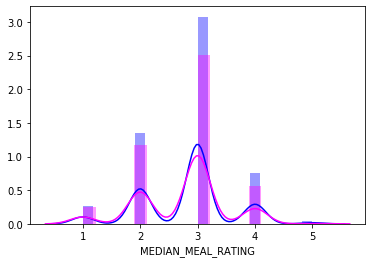

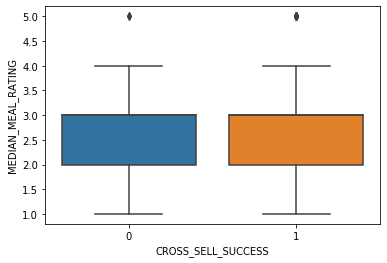

In [21]:
# New variable is created

followed_vector = []

for value in df.loc[:, "FOLLOWED_RECOMMENDATIONS_PCT"]:
    
    if value > 30:
        
        followed_vector.append(1)
        
    else:
        
        followed_vector.append(0)
        
df.loc[:, "followed_above_30"] = followed_vector

# Plots and summary statistics are generated

var_being_used = "MEDIAN_MEAL_RATING"

print("-" * 80, "\nFollowed recommendations over 30% of the times\n", "-" * 80, sep = "")

display(df.loc[df.followed_above_30 == 1, var_being_used].describe())

print("-" * 80, "\nFollowed recommendations up to 30% of the times\n", "-" * 80, sep = "")

display(df.loc[df.followed_above_30 == 0, var_being_used].describe())

sns.distplot(df.loc[df.CROSS_SELL_SUCCESS == 1, var_being_used], color = "b")

sns.distplot(df.loc[df.CROSS_SELL_SUCCESS == 0, var_being_used], color = "fuchsia")

plt.show()

sns.boxplot(x = df.loc[:, "CROSS_SELL_SUCCESS"],
             y = df.loc[:, var_being_used])

plt.show()

The same kind of comparison was made between customers below 30% of recommendations followed who adopted or rejected Halfway There. Again, no important differences were found for any of the variables in the data set.

--------------------------------------------------------------------------------
Adopter, less than 30% of recommendations followed
--------------------------------------------------------------------------------


count     537.000000
mean     2141.653864
std      1117.914425
min       131.000000
25%      1395.000000
50%      1750.000000
75%      2712.500000
max      7550.000000
Name: REVENUE, dtype: float64

--------------------------------------------------------------------------------
Rejecter, less than 30% of recommendations followed
--------------------------------------------------------------------------------


count     625.000000
mean     2099.780800
std      1136.706676
min       440.000000
25%      1330.000000
50%      1725.000000
75%      2730.000000
max      7473.375000
Name: REVENUE, dtype: float64

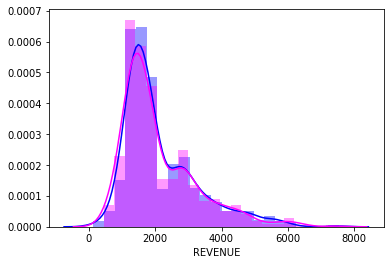

In [7]:
# Plots and summary statistics are generated

var_being_used = "REVENUE"

print("-" * 80, "\nAdopter, less than 30% of recommendations followed\n", "-" * 80, sep = "")

display(df.loc[(df.followed_above_30 == 0) & (df.CROSS_SELL_SUCCESS == 1) , var_being_used].describe())

print("-" * 80, "\nRejecter, less than 30% of recommendations followed\n", "-" * 80, sep = "")

display(df.loc[(df.followed_above_30 == 0) & (df.CROSS_SELL_SUCCESS == 0) , var_being_used].describe())

sns.distplot(df.loc[(df.followed_above_30 == 0) & (df.CROSS_SELL_SUCCESS == 1) , var_being_used], color = "b")

sns.distplot(df.loc[(df.followed_above_30 == 0) & (df.CROSS_SELL_SUCCESS == 0) , var_being_used], color = "fuchsia")

plt.show()

5. Closer look on EMAIL

Since the use of a professional or junk email seemed to be important, a more granular look was taken on the EMAIL variable. Each email domain was looked into separately, the total number of adopters and rejecters was computed. The ratio between adopters and rejecters was calculated to identify which email domains show the most loyalty.

Using this value, email domains were re-categorized as high, medium, low, or no loyalty. Three email domains (gmail, yahoo, and protonmail) were put in a category of their own, due to the fact that they are the domains with the most users and could be different from other domains at a similar level of loyalty.

The next cell outputs a table of all email domains and their corresponding adopters, rejecters, and ratio. We can see that the most loyal customers of Halfway There belong to five companies: Merck, Microsoft, PG, JPMorgan, and Intel. Other companies show medium to low levels of loyalty.

While domains categorized as junk are indeed the ones who show the lowest loyalty, and professional domains have an overall higher level of acceptance, we can see that there are several companies in our customer base who we could target more aggressively.

In [8]:
# String is separated and dummy variables are created

domain_vector = []

for email in df.loc[:, "EMAIL"]:
    
    domain_vector.append(email.split(sep = "@")[1])
    
df.loc[:, "email_domain"] = domain_vector

email_dummies = pd.get_dummies(df.loc[:, "email_domain"])

df = df.join(email_dummies)

# Values are calculated for each domain

accepted = df.loc[df.CROSS_SELL_SUCCESS == 1, "email_domain"].value_counts()
rejected = df.loc[df.CROSS_SELL_SUCCESS == 0, "email_domain"].value_counts()

# A data frame is created

accepted = pd.DataFrame(accepted)

rejected = pd.DataFrame(rejected)

domains = pd.concat([accepted, rejected], axis=1)

domains.columns = ["accepted", "rejected"]

domains.loc[:, "ratio"] = domains.loc[:, "accepted"] / domains.loc[:, "rejected"]

domains = domains.sort_values(by = "ratio", ascending = False)

display(domains)

# Emails are categorized

high_loyalty = ["merck.com", "microsoft.com", "pg.com", "jpmorgan.com", "intel.com"]

mid_loyalty = ["amex.com", "caterpillar.com", "unitedtech.com",
               "goldmansacs.com", "unitedhealth.com", "verizon.com",
              "walmart.com", "pfizer.com", "cocacola.com", "mcdonalds.com",
              "boeing.com", "cisco.com", "nike.com", "apple.com", "mmm.com",
              "ge.org", "travelers.com", "visa.com"]

low_loyalty = ["ibm.com", "dupont.com", "chevron.com", "disney.com", 
               "jnj.com", "exxon.com"]

no_loyalty = ["homedepot.com", "passport.com", "me.com", "live.com", 
              "msn.com", "hotmail.com", "aol.com"]

public_domains = ["protonmail.com", "gmail.com", "yahoo.com"]

# New variables are created based on the new categorization

email_type_vector = []

for email in df.loc[:, "email_domain"]:
    
    if email in high_loyalty:
        
        email_type_vector.append("high_loyalty")
        
    elif email in mid_loyalty:
        
        email_type_vector.append("mid_loyalty")
        
    elif email in low_loyalty:
        
        email_type_vector.append("low_loyalty")
        
    elif email in no_loyalty:
        
        email_type_vector.append("no_loyalty")
        
    elif email in public_domains:
        
        email_type_vector.append("public_domains")
        
    else:
        
        email_type_vector.append("other")
    
df.loc[:, "email_type"] = email_type_vector

# Creating dummy variables based on email type

email_dummies = pd.get_dummies(df.loc[:, "email_type"])

df = df.join(email_dummies)

# Dropping email related variables after encoding

df = df.drop("EMAIL", axis = 1)

df = df.drop("email_type", axis = 1)

# Dropping one of the dummy variables created to avoid colinearity

df = df.drop("low_loyalty", axis = 1)

C:\Users\lueda\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,accepted,rejected,ratio
merck.com,27,1,27.000000
microsoft.com,24,1,24.000000
pg.com,21,1,21.000000
jpmorgan.com,18,1,18.000000
intel.com,16,1,16.000000
amex.com,27,3,9.000000
caterpillar.com,19,3,6.333333
unitedtech.com,15,3,5.000000
goldmansacs.com,15,3,5.000000
unitedhealth.com,20,4,5.000000


Comparisons similar to the ones made between customers above and below 30% of recommendations followed were made for Gmail, Yahoo, and Protonmail users. Slight differences were found between adopters and rejecters for the variables "REVENUE", "AVG_TIME_PER_VISIT", and "TOTAL_PHOTOS_VIEWED". These differences were nevertheless not consistent across email domains, and thus do not seem to explain the behavior of users of public email domains.

The next cell shows the framework used for the comparisons, showing one example with Gmail users and one variable.

--------------------------------------------------------------------------------
Gmail user, adopter
--------------------------------------------------------------------------------


count     213.000000
mean     1998.279930
std       968.431697
min       222.250000
25%      1300.000000
50%      1719.000000
75%      2572.500000
max      5380.000000
Name: REVENUE, dtype: float64

--------------------------------------------------------------------------------
Gmail user, rejecter
--------------------------------------------------------------------------------


count      90.000000
mean     2319.413889
std      1149.701143
min       623.000000
25%      1415.000000
50%      1942.500000
75%      3005.000000
max      6116.000000
Name: REVENUE, dtype: float64

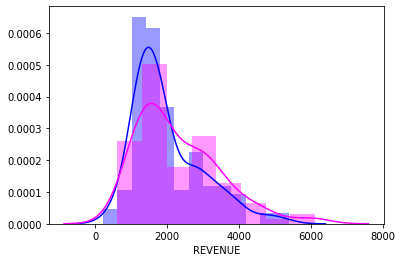

In [9]:
# Plots and summary statistics are generated

var_being_used = "REVENUE"

print("-" * 80, "\nGmail user, adopter\n", "-" * 80, sep = "")

display(df.loc[(df.email_domain == "gmail.com") & (df.CROSS_SELL_SUCCESS == 1) , var_being_used].describe())

print("-" * 80, "\nGmail user, rejecter\n", "-" * 80, sep = "")

display(df.loc[(df.email_domain == "gmail.com") & (df.CROSS_SELL_SUCCESS == 0) , var_being_used].describe())

sns.distplot(df.loc[(df.email_domain == "gmail.com") & (df.CROSS_SELL_SUCCESS == 1) , var_being_used], color = "b")

sns.distplot(df.loc[(df.email_domain == "gmail.com") & (df.CROSS_SELL_SUCCESS == 0) , var_being_used], color = "fuchsia")

plt.show()

6. Model evaluation

Seven sets of candidate predictor variables were created with combinations of the "FOLLOWED_RECOMMENDATIONS_PCT" variable, different categorizations of emails, the domains themselves, and the variables found to have slight differences for public email domains. These seven candidate sets were tested with 10 diffent kinds of models:

    LogisticRegression
    RidgeClassifier
    PassiveAggressiveClassifier
    SGDClassifier
    KNeighborsClassifier
    LinearSVC
    NuSVC
    DecisionTreeClassifier
    AdaBoostClassifier
    GradientBoostingClassifier
    RandomForestClassifier
    BaggingClassifier
    
For every model type, grid search with cross validation was used to find the best hyperparameters. The model found to be most accurate was a GradientBoostingClassifier.

In [10]:
# Dataset options are created

vars_1 = ["FOLLOWED_RECOMMENDATIONS_PCT", "professional", "junk"]

vars_2 = ["FOLLOWED_RECOMMENDATIONS_PCT", "professional", "junk", 
          "high_loyalty", "mid_loyalty", "no_loyalty", "public_domains"]

vars_3 = ["FOLLOWED_RECOMMENDATIONS_PCT", "high_loyalty", "mid_loyalty", 
          "no_loyalty", "public_domains"]

vars_4 = ["FOLLOWED_RECOMMENDATIONS_PCT", "high_loyalty", "mid_loyalty", 
          "no_loyalty", "public_domains", "REVENUE", "AVG_TIME_PER_SITE_VISIT",
          "TOTAL_PHOTOS_VIEWED"]

vars_5 = ["FOLLOWED_RECOMMENDATIONS_PCT", "professional", "junk", 
          "high_loyalty", "mid_loyalty", "no_loyalty", "public_domains",
         "REVENUE", "AVG_TIME_PER_SITE_VISIT", "TOTAL_PHOTOS_VIEWED"]

vars_6 = ["FOLLOWED_RECOMMENDATIONS_PCT", "professional", "junk", "merck.com",
          "microsoft.com", "pg.com", "jpmorgan.com", "intel.com", "amex.com", 
          "caterpillar.com", "unitedtech.com", "goldmansacs.com", 
          "unitedhealth.com", "verizon.com", "walmart.com", "pfizer.com", 
          "cocacola.com", "mcdonalds.com", "boeing.com", "cisco.com", 
          "nike.com", "apple.com", "mmm.com", "ge.org", "travelers.com", 
          "visa.com", "ibm.com", "dupont.com", "chevron.com", "disney.com",  
          "jnj.com", "exxon.com",  "homedepot.com", "passport.com", "me.com", 
          "live.com",  "msn.com", "hotmail.com", "aol.com", "protonmail.com", 
          "gmail.com", "yahoo.com"]

vars_7 = ["FOLLOWED_RECOMMENDATIONS_PCT", "professional", "junk", "merck.com",
          "microsoft.com", "pg.com", "jpmorgan.com", "intel.com", "amex.com", 
          "caterpillar.com", "unitedtech.com", "goldmansacs.com", 
          "unitedhealth.com", "verizon.com", "walmart.com", "pfizer.com", 
          "cocacola.com", "mcdonalds.com", "boeing.com", "cisco.com", 
          "nike.com", "apple.com", "mmm.com", "ge.org", "travelers.com", 
          "visa.com", "ibm.com", "dupont.com", "chevron.com", "disney.com",  
          "jnj.com", "exxon.com",  "homedepot.com", "passport.com", "me.com", 
          "live.com",  "msn.com", "hotmail.com", "aol.com", "protonmail.com", 
          "gmail.com", "yahoo.com", "REVENUE", "AVG_TIME_PER_SITE_VISIT", 
          "TOTAL_PHOTOS_VIEWED"]

The following cell shows an example of the grid search framework used to evaluate all models, using a KNeighborsClassifier. For every model the best parameters were identified, along with training and testing scores, and the AUC.

AUC values ranged between 0.5 and 0.82

In [11]:
df_data = df.loc[:, vars_4]

df_target = df.loc[:, "CROSS_SELL_SUCCESS"]

scaler = StandardScaler()

scaler.fit(df_data)

X_scaled = scaler.transform(df_data)

X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = df_data.columns

X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                   df_target,
                                                   test_size = 0.25,
                                                   random_state = 222)

n_neighbors_param = np.arange(5, 7, 1)

weights_param = ["uniform", "distance"] 

algorithm_param = ["auto", "ball_tree", "kd_tree", "brute"] 

param_grid = {"n_neighbors" : n_neighbors_param,
             "weights" : weights_param,
             "algorithm" : algorithm_param}

#Instantiating and training model

model = KNeighborsClassifier()

model_cv = GridSearchCV(model, 
                          param_grid, 
                          cv=5,)

model_cv.fit(X_scaled, df_target)

model_tuned = model_cv.best_estimator_

model_pred = model_tuned.predict(X_test)

# Printing scores

print("Tuned Parameters  :", model_cv.best_params_)

print("Confusion Matrix  :\n", confusion_matrix(y_true = y_test,
                       y_pred = model_pred))

print("Training score  :", model_cv.score(X_train, y_train).round(4))
print("Testing score  :", model_cv.score(X_test, y_test).round(4))

print("AUC  :", roc_auc_score(y_true  = y_test,
              y_score = model_pred).round(4))

Tuned Parameters  : {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}
Confusion Matrix  :
 [[135  24]
 [ 68 260]]
Training score  : 0.8033
Testing score  : 0.8111
AUC  : 0.8209


7. Training of final model

The best model created was the GradientBoostingRegressor presented in the next cell. It uses as input the following variables:

    "FOLLOWED_RECOMMENDATIONS_PCT" 
    "professional" 
    "junk"
    "high_loyalty"
    "mid_loyalty"
    "no_loyalty"
    "public_domains"
    
It has an AUC of 0.8281. With a sensitivity of 0.79 and a specificity of 0.84, it is slightly better at identifying customers who will not sign up for Halfway There. This is convenient, as marketing resources can be better used if not spent on low potential leads.

In [12]:
df_data = df.loc[:, vars_2]

df_target = df.loc[:, "CROSS_SELL_SUCCESS"]

X_train, X_test, y_train, y_test = train_test_split(df_data,
                                                   df_target,
                                                   test_size = 0.25,
                                                   random_state = 222)

gb = GradientBoostingClassifier(loss = "deviance", n_estimators = 500)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

c_mat = confusion_matrix(y_true = y_test,
                       y_pred = model_pred)

print("Confusion Matrix :\n", c_mat)

print("Training score :", gb.score(X_train, y_train).round(4))

print("Testing score :", gb.score(X_test, y_test).round(4))

print("Sensitivity :", (c_mat[1][1]/(c_mat[1][1]+c_mat[1][0])).round(4))

print("Specificity :", (c_mat[0][0]/(c_mat[0][0]+c_mat[0][1])).round(4))

print("AUC :", roc_auc_score(y_true  = y_test,
              y_score = gb_pred).round(4))

Confusion Matrix :
 [[135  24]
 [ 68 260]]
Training score : 0.7889
Testing score : 0.8296
Sensitivity : 0.7927
Specificity : 0.8491
AUC : 0.8281


In [28]:
domains.iloc[:, :2]

,accepted,rejected
merck.com,27,1
microsoft.com,24,1
pg.com,21,1
jpmorgan.com,18,1
intel.com,16,1
amex.com,27,3
caterpillar.com,19,3
unitedtech.com,15,3
goldmansacs.com,15,3
unitedhealth.com,20,4


REFERENCES

Dubé, J. P., Hitsch, G. J., & Rossi, P. E. (2010). State dependence and alternative explanations for consumer inertia. The RAND Journal of Economics, 41(3), 417-445.